In [2]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
train_data = pd.read_csv('resamp_training_data.csv')

X_train_resampled = train_data.drop(columns=['stroke'])
y_train_resampled = train_data['stroke']

test_data = pd.read_csv('resamp_test_data.csv')
X_test = test_data.drop(columns=['stroke'])
y_test = test_data['stroke']

<font color="bluegrey" size=+1.0><b>Random Forest</b></font>

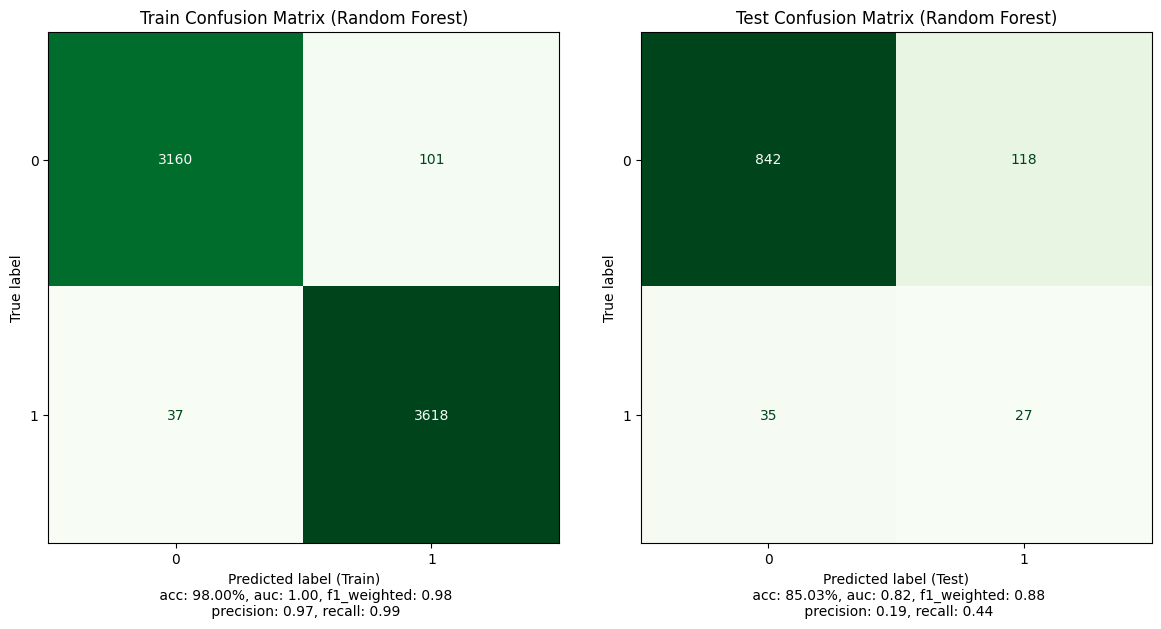

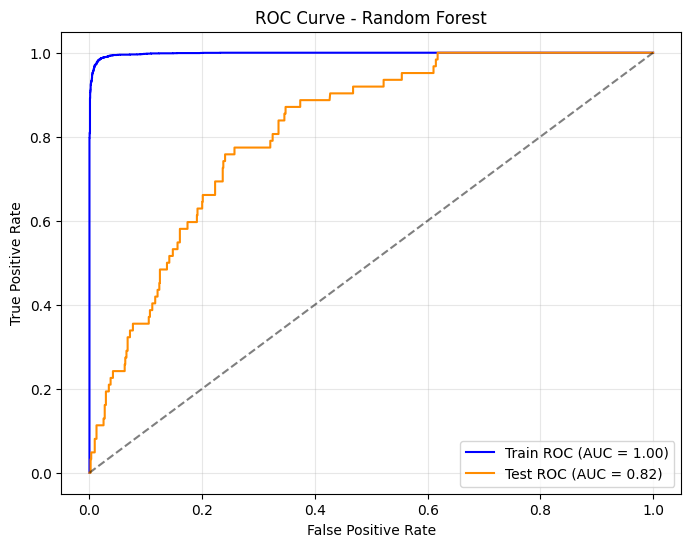

Random Forest Performance on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       960
           1       0.19      0.44      0.26        62

    accuracy                           0.85      1022
   macro avg       0.57      0.66      0.59      1022
weighted avg       0.91      0.85      0.88      1022

Training Accuracy: 0.9800
Training ROC AUC Score: 0.9985
Test Accuracy: 0.8503
Test ROC AUC Score: 0.8157


In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')

rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_hat_train_rf = rf_model.predict(X_train_resampled)
y_hat_test_rf = rf_model.predict(X_test)

y_hat_prob_train_rf = rf_model.predict_proba(X_train_resampled)[:, 1]
y_hat_prob_test_rf = rf_model.predict_proba(X_test)[:, 1]

# Binary threshold
binary_threshold = 0.5
y_pred_sigmoid_train_rf = (y_hat_prob_train_rf >= binary_threshold).astype(int)
y_pred_sigmoid_test_rf = (y_hat_prob_test_rf >= binary_threshold).astype(int)

# Evaluation (Train)
train_accuracy_rf = accuracy_score(y_train_resampled, y_pred_sigmoid_train_rf)
train_roc_auc_rf = roc_auc_score(y_train_resampled, y_hat_prob_train_rf)
train_f1_weighted_rf = f1_score(y_train_resampled, y_pred_sigmoid_train_rf, average='weighted')
train_precision_rf = precision_score(y_train_resampled, y_pred_sigmoid_train_rf)
train_recall_rf = recall_score(y_train_resampled, y_pred_sigmoid_train_rf)

# Evaluation (Test)
test_accuracy_rf = accuracy_score(y_test, y_pred_sigmoid_test_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_hat_prob_test_rf)
test_f1_weighted_rf = f1_score(y_test, y_pred_sigmoid_test_rf, average='weighted')
test_precision_rf = precision_score(y_test, y_pred_sigmoid_test_rf)
test_recall_rf = recall_score(y_test, y_pred_sigmoid_test_rf)

# Confusion matrices with metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train Confusion Matrix
cm_train_rf = confusion_matrix(y_train_resampled, y_pred_sigmoid_train_rf)
disp_train_rf = ConfusionMatrixDisplay(confusion_matrix=cm_train_rf)
disp_train_rf.plot(cmap='Greens', ax=axes[0], colorbar=False)
axes[0].set_xlabel(f"Predicted label (Train)\n acc: {train_accuracy_rf*100:.2f}%, auc: {train_roc_auc_rf:.2f}, f1_weighted: {train_f1_weighted_rf:.2f}\n precision: {train_precision_rf:.2f}, recall: {train_recall_rf:.2f}")
axes[0].set_title('Train Confusion Matrix (Random Forest)')

# Test Confusion Matrix
cm_test_rf = confusion_matrix(y_test, y_pred_sigmoid_test_rf)
disp_test_rf = ConfusionMatrixDisplay(confusion_matrix=cm_test_rf)
disp_test_rf.plot(cmap='Greens', ax=axes[1], colorbar=False)
axes[1].set_xlabel(f"Predicted label (Test)\n acc: {test_accuracy_rf*100:.2f}%, auc: {test_roc_auc_rf:.2f}, f1_weighted: {test_f1_weighted_rf:.2f}\n precision: {test_precision_rf:.2f}, recall: {test_recall_rf:.2f}")
axes[1].set_title('Test Confusion Matrix (Random Forest)')

plt.tight_layout()
plt.show()

# ROC Curve
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train_resampled, y_hat_prob_train_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_hat_prob_test_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f'Train ROC (AUC = {train_roc_auc_rf:.2f})', color='blue')
plt.plot(fpr_test_rf, tpr_test_rf, label=f'Test ROC (AUC = {test_roc_auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Classification Report
print("Random Forest Performance on Test Set:")
print(classification_report(y_test, y_pred_sigmoid_test_rf))

print(f"Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Training ROC AUC Score: {train_roc_auc_rf:.4f}")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Test ROC AUC Score: {test_roc_auc_rf:.4f}")

<font color="bluegrey" size=+1.0><b>XGBoost</b></font>

In [10]:
scale_pos_weight = len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1])
xgb_model = XGBClassifier(random_state=42, max_depth=6, learning_rate=0.1, n_estimators=100, scale_pos_weight=scale_pos_weight)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_xgb)}")

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       960
           1       0.16      0.35      0.22        62

    accuracy                           0.85      1022
   macro avg       0.56      0.62      0.57      1022
weighted avg       0.91      0.85      0.87      1022

Accuracy: 0.8493150684931506
ROC AUC Score: 0.8096270161290323


<font color="bluegrey" size=+1.0><b>Neural Network</b></font>

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the features for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define Neural Network Architecture
nn_model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_scaled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
y_pred_nn_prob = nn_model.predict(X_test_scaled).ravel()
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_nn_prob)}")

Epoch 1/50


c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7142 - loss: 0.5275 - val_accuracy: 0.7290 - val_loss: 0.5480
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8485 - loss: 0.3487 - val_accuracy: 0.7446 - val_loss: 0.5134
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8613 - loss: 0.3342 - val_accuracy: 0.7378 - val_loss: 0.5616
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8766 - loss: 0.3018 - val_accuracy: 0.7348 - val_loss: 0.5559
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8796 - loss: 0.2868 - val_accuracy: 0.7299 - val_loss: 0.5791
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8819 - loss: 0.2838 - val_accuracy: 0.7309 - val_loss: 0.5759
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8908 - loss: 0.2653 - val_accuracy: 0.7613 - val_loss: 0.5093
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8995 - loss: 0.2414 - val_accuracy: 0.7368 - val_

<font color="bluegrey" size=+1.0><b>Validation Accuracy & Loss</b></font>

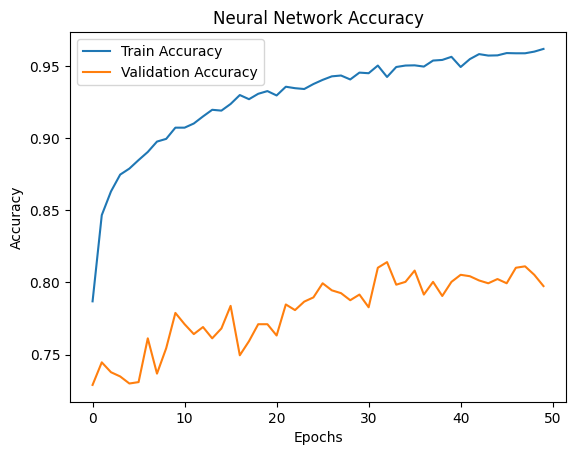

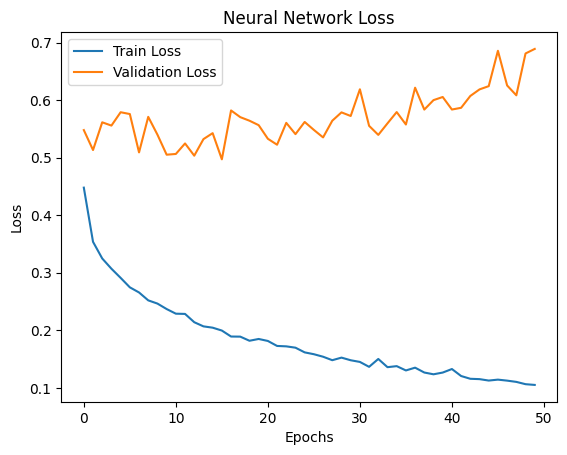

In [6]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<font color="bluegrey" size=+1.0><b>Visualisations</b></font>

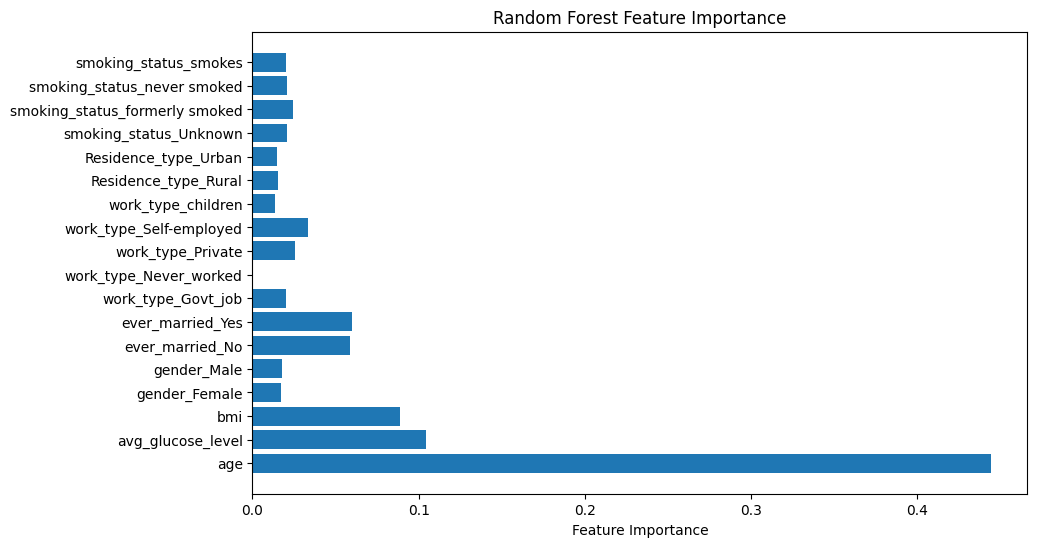

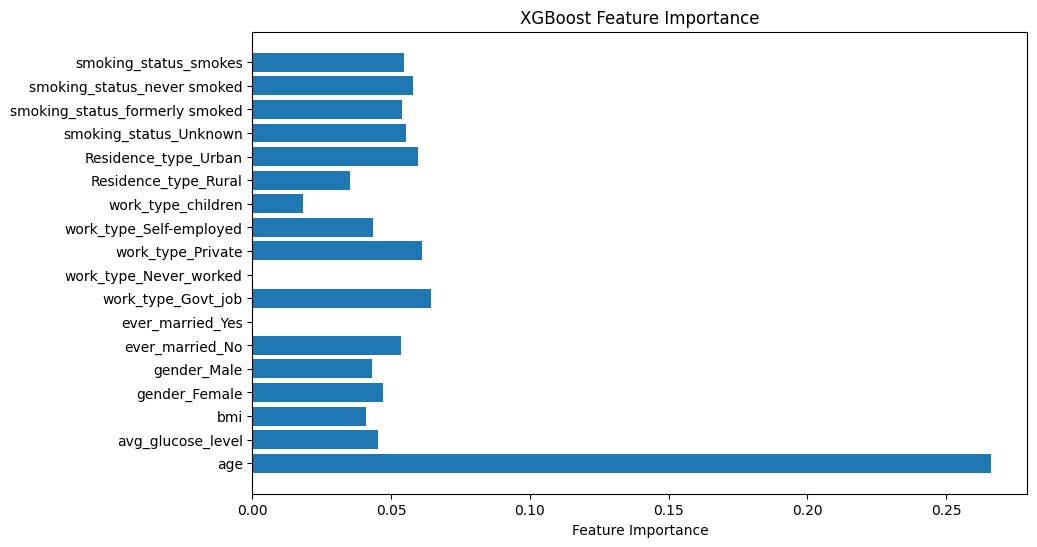

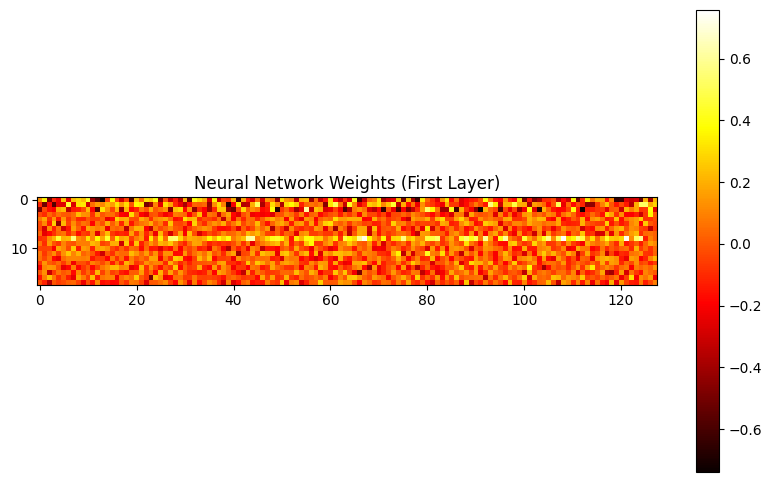

In [7]:
# Random Forest
plt.figure(figsize=(10, 6))
plt.barh(X_train_resampled.columns, rf_model.feature_importances_) 
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# XGBoost
plt.figure(figsize=(10, 6))
plt.barh(X_train_resampled.columns, xgb_model.feature_importances_) 
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

# Neural Network
weights = nn_model.layers[0].get_weights()[0]  # weights of the first layer
biases = nn_model.layers[0].get_weights()[1]  # biases of the first layer (if needed)

plt.figure(figsize=(10, 6))
plt.imshow(weights, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Neural Network Weights (First Layer)")
plt.show()

<font color="bluegrey" size=+1.0><b>Save results</b></font>

In [8]:
# Compare model results
results = {
    "Model": ["Random Forest", "XGBoost", "Neural Network"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_nn)],
    "ROC AUC": [roc_auc_score(y_test, y_pred_prob_f), roc_auc_score(y_test, y_pred_prob_xgb), roc_auc_score(y_test, y_pred_nn_prob)]
}

results_df = pd.DataFrame(results)
print(results_df)

            Model  Accuracy   ROC AUC
0   Random Forest  0.824853  0.820296
1         XGBoost  0.849315  0.809627
2  Neural Network  0.797456  0.787903


<font color="bluegrey" size=+1.0><b>Save models</b></font>

In [9]:
from joblib import dump

dump(rf_model, 'random_forest_model.pkl')
dump(xgb_model, 'xgboost_model.pkl')
dump(nn_model, 'neural_network_model.pkl')
print("Successfully saved the models.")

Successfully saved the models.
